# Aula 2 - Parte Prática - Policy Gradients 

## Introdução

Nesse segundo notebook vamos aprender como melhorar o desempenho de um agente ao longo do tempo com base em experiências. Para isso, representaremos a política $\pi_\theta$ do agente por meio de uma rede neural de parâmetros $\theta$.

<img src="img/policy-net-agent-env-loop.png" alt="Agent-Env Loop" style="width: 550px;"/>

A abordagem que iremos estudar é conhecida por **Otimização de Política** baseada em gradientes (outro nome comum encontrado na literatura é Busca de Política (*Policy Search*)). De maneira geral, essa classe de algoritmos de RL é denominada como **Policy Gradients**.

Começaremos a explorar Policy Gradients nesse notebook com uma implementação básica. A fim de desenvolver gradualmente seus principais componentes e entender o papel de cada um deles, iremos de forma didática construir o algoritmo **REINFORCE**.

$$
\nabla_\theta J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta} \left [ \sum_{t=0}^{T-1} \nabla_\theta \log \pi_\theta(\mathbf{a}_t|\mathbf{s}_t)  \sum_{t'=0}^{T-1} r_{t'+1} \right ]
$$


### Objetivos:

- Entender a abordagem de otimização de políticas como busca no espaço de parâmetros da política
- Implementar um primeiro agente baseado no algoritmo REINFORCE
- Familiarizar-se com a API básica de construção de modelos (i.e., redes neurais) em Keras
- Familiarizar-se com métodos de Deep Learning usando TensorFlow 2.X

### Imports

> **Atenção:** não se esqueça de executar todos os `imports` necessários antes prosseguir com o tutorial.

In [1]:
import logging

import gym
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

from utils.agent import RLAgent
from utils.memory import OnPolicyReplay
import utils.runner
from utils.viz import *

# sanity check
assert tf.__version__ == '2.1.0'
assert tf.executing_eagerly()

tf.get_logger().setLevel('ERROR') # ignore TensorFlow warnings
gym.logger.set_level(logging.ERROR)

Loading BokehJS ...

## 1. Redes Neurais em TensorFlow e Keras

Antes de começarmos propriamente com a implementação do algoritmo REINFORCE visto em aula. Iremos introduzir em linhas gerais a biblioteca de construção de modelos (i.e., redes neurai artificiais) do Keras no TensorFlow.

A grosso modo, a API do Keras é uma camada de *software* implementada em cima das funções, classes e métodos dos pacotes de Deep Learning com o objetivo de facilitar a implementação, treinameto e avaliação de redes neurais. Maiores detalhes sobre a especificação do Keras podem ser acessadas em [https://keras.io/](https://keras.io/). A documentação específica da implementação do Keras para TensorFlow se encontra em [https://www.tensorflow.org/guide/keras](https://www.tensorflow.org/guide/keras).

Note que a biblioteca do Keras é bastante extensa e flexível, de forma que nesse tutorial nos restringiremos a apresentar na medida do necessário os conceitos básicos necessários para trabalhar com redes neurais no contexto de Aprendizado por Reforço, e em particular, com foco nas primitivas necessárias para se implementar Policy Gradients.

> **Observação**: para aqueles interessados em uma introdução mais detalhada, sugerimos seguir após a aula os tutoriais do Tensorflow (e.g., https://www.tensorflow.org/tutorials/quickstart/beginner).


### 1.1 Camadas e Modelos Sequenciais

A rede neural mais simples que podemos construir é conhecida por *[Multi-Layer Perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron)* (MLP). Também conhecida por *Feedforward* ou *Fully-connected Network*.

Uma MLP é definida pela composição de camadas de transformações afins, $h: \mathbb{R}^q \rightarrow \mathbb{R}^p$, seguidas por uma função não-linear (e.g., *activation*):
$
h(\mathbf{x}) = \text{activation}(\mathbf{W}_{p \times q} \cdot \mathbf{x}_{q \times 1} + \mathbf{b}_{p \times 1})
$ .

Recentemente, tem se tornado bastante comum o uso da função de ativação ReLU (*Rectified Linear Unit*):
$
\text{ReLU}(x) = max(0, x)
$ .

> **Observação**: para esse curso não será necessário se aprofundar muito em redes neurais ou *Deep Learning*, no entanto, sugerimos como material auxiliar os excelentes vídeos explicativos sobre Redes Neurais do *3BLUE1BROWN* (https://www.3blue1brown.com/neural-networks).

No Keras podemos utilizar a classe `tf.keras.layers.Dense` para construir a função $h(\cdot)$ e a classe `tf.keras.Sequential` para encadear essas transformações (comumente chamadas de *camadas*):

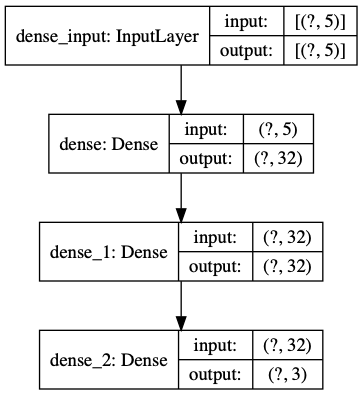

In [2]:
mlp = tf.keras.Sequential([
    tf.keras.layers.Dense(32, input_shape=(5,), activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(3, activation="relu"),
])

tf.keras.utils.plot_model(mlp, show_shapes=True)

In [3]:
x = np.random.normal(size=(5,))
y = mlp(x[None,:])

print(f">> mlp(x) transforma vetores `x` de tamanho {x.shape[-1]} em vetores `y` de tamanho {y.shape[-1]}")

>> mlp(x) transforma vetores `x` de tamanho 5 em vetores `y` de tamanho 3


É importante observar que camadas e modelos em Keras esperam receber vetores em *batch*. Dessa forma, é possível processar conjuntos de vetores em paralelo; o que torna a computação consideravelmente mais eficiente.

No exemplo anterior, a variável `x = np.random.normal(size=(5,))` representa um único vetor de tamanho 5. Dessa forma, é necessário adicionar uma dimensão extra através do truque de manipulação de tensores `x[None,:]`.

In [4]:
x = np.random.normal(size=(5,))
assert x.shape == (5,)
assert x[None,:].shape == (1, 5)

Para processar vetores em *batch*, o Keras assume que a primeira dimensão do vetor corresponde ao `batch_size`:

In [5]:
batch_size = 128
x = np.random.normal(size=(batch_size, 5))
y = mlp(x)

print(f">> mlp(x) transformou {x.shape[0]} vetores `x` de tamanho {x.shape[-1]} em {y.shape[0]} vetores `y` de tamanho {y.shape[-1]}")

>> mlp(x) transformou 128 vetores `x` de tamanho 5 em 128 vetores `y` de tamanho 3


### 1.2 Camadas Probabilísticas

Em Aprendizado por Reforço é muitas vezes necessário representar distribuições (i.e., variáveis aleatórias). Por exemplo, na próxima seção utilizaremos uma distribuições para representar política estocásticas definida para um espaço discreto de ações.

Em TensorFlow 2.X é fácil representar as principais distribuições através da biblioteca `tensorflow_probability` (https://www.tensorflow.org/probability).

> **Observação**: para os interessados em modelos probabilísticos e inferência, recomendamos revisar após a aula o tutorial sobre regressão usando o TensorFlow Probability disponível em https://blog.tensorflow.org/2019/03/regression-with-probabilistic-layers-in.html.

Para esse tutorial precisaremos representar **distribuições categóricas** (https://en.wikipedia.org/wiki/Categorical_distribution) de forma a amostrar valores discretos ou classes (representadas por números inteiros) de acordo com um vetor de probabilidades.

Lembre-se que para uma variável $x \in \{1, 2, \cdots, K\}$ e um vetor de probabilidades $[p_1, p_2, \cdots, p_K]$ (i.e., $p_i \in [0, 1], \sum_{i=1}^K p_i = 1$), temos que:

$$
x \sim \text{Categorical}([p_1, p_2, \cdots, p_K]) \Leftrightarrow P(x = i) = p_i
$$

No TensorFlow podemos adicionar um camada probabilística através da classe `tfp.layers.DistributionLambda`:

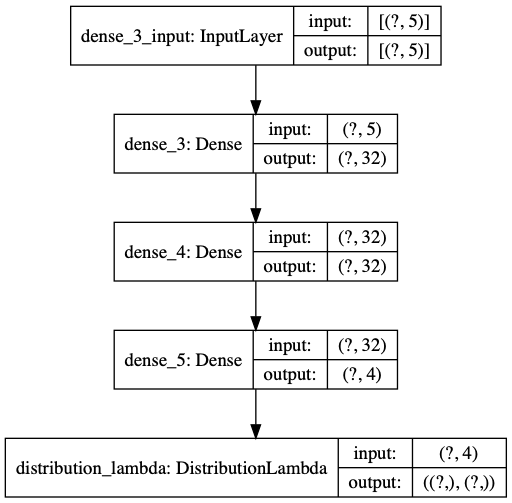

In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, input_shape=(5,), activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(4),
    tfp.layers.DistributionLambda(lambda t: tfd.Categorical(logits=t))
])

tf.keras.utils.plot_model(model, show_shapes=True)

Se invocarmos a rede neural implementada pela variável `model` em um conjunto de vetores de entrada `inputs`, observamos que a saída corresponde a um objeto do tipo `tfp.distributions.Categorical` e não a valores da variável aleatória:

In [7]:
inputs = np.random.normal(size=(8, 5))

dist = model(inputs)
print(dist)

tfp.distributions.Categorical("sequential_1_distribution_lambda_Categorical", batch_shape=[8], event_shape=[], dtype=int32)


> **Atenção**: observe como o modelo representa uma distribuição parametrizada (e.g., os parâmetros de uma categórica são conhecidos por`logits`). As primeiras camadas do tipo `Dense` processam os vetores de entrada gerando um conjunto de vetores de *logits* usados para definir a distribuição condicional categórica. Em outras palavras, para cada vetor de entrada temos uma distribuição categórica (por isso dizemos que o modelo representa uma distribuição condicional, isto é, condicionada no vetor de entrada.

Para amostrar realizações da variável aleatória dada pela distribuição categórica, utilizamos o método `sample()` (disponível para todas as distribuições definidas no TensorFlow Probability):

In [8]:
sample = dist.sample()
print(sample)

tf.Tensor([2 3 0 1 2 3 0 1], shape=(8,), dtype=int32)


> **Atenção**: note que embora a entrada do `model` seja um array n-dimensional no NumPy, uma amostra da distribuição é um objeto `Tensor` do TensorFlow. Você pode usar o método `numpy()` para transformar `tf.Tensor` em um `np.ndarray`.

Outro método importante para se familiarizar é `log_prob`. Dada uma amostra ou vetores de amostra, o método `log_prob` devolve o logaritmo da probabilidade de se ter gerado a amostra.

In [9]:
sample_log_prob = dist.log_prob(sample)
print(sample_log_prob)

tf.Tensor(
[-1.4785905 -0.9418134 -1.6792542 -1.7414051 -1.2990601 -1.0575057
 -1.5646884 -1.5338118], shape=(8,), dtype=float32)


> **Atenção**: o método `log_prob` será fundamental na implementação dos algoritmos de *Policy Gradientes* nessse curso. Tenha certeza que você compreendeu seu funcionamento em termos de entradas e saídas da função.

## 2. Implementando políticas estocásticas em tf.Keras

Nesse tutorial iremos trabalhar com problemas do OpenAI gym que são definidos para um espaço discreto de ações. Dessa forma, precisaremos representar políticas estocásticas  $\pi_\theta(\mathbf{a}_t | \mathbf{s}_t)$ para ações discretas. Para isso, utilizaremos redes neurais construídas via Keras.

<img src="img/policy-net.png" alt="Agent-Env Loop" style="width: 550px;"/>

Para não perdermos tempo com detalhes de implementação, disponibilizamos a função `build_discrete_policy` que recebe as especificações dos espaços de observação e ação do ambiente e os hiper-parâmetros que definem a arquitetura da rede neural:

In [10]:
def build_discrete_policy(obs_space, action_space, hidden_layers, activation="relu"):
    Input = tf.keras.Input
    Dense = tf.keras.layers.Dense
    DistributionLambda = tfp.layers.DistributionLambda
    Categorical = tfd.Categorical
    
    policy_net_layers = []

    policy_net_layers.append(Input(shape=obs_space.shape, name="State"))

    for i, units in enumerate(hidden_layers):
        policy_net_layers.append(Dense(units=units, activation=activation, name=f"Hidden{i+1}"))
    
    policy_net_layers.append(Dense(units=action_space.n, name="Logits"))
    policy_net_layers.append(DistributionLambda(lambda t: Categorical(logits=t), name="Action_Distribution_Categorical"))
                                     
    return tf.keras.Sequential(policy_net_layers)


Execute o código abaixo para criar um modelo com 2 camadas de 64 unidades utilizando o `relu` como função de ativação:

In [11]:
env = gym.make("CartPole-v0")

hidden_layers = [64, 64]
activation = "relu"

policy = build_discrete_policy(env.observation_space, env.action_space, hidden_layers, activation)

obs = env.observation_space.sample()
action_dist = policy(obs[None,:])

action = action_dist.sample().numpy()
assert action[0] in env.action_space

Você pode inspecionar visualmente a arquitetura da política (e de qualquer modelo no Keras) através da função `tf.keras.utils.plot_model`:

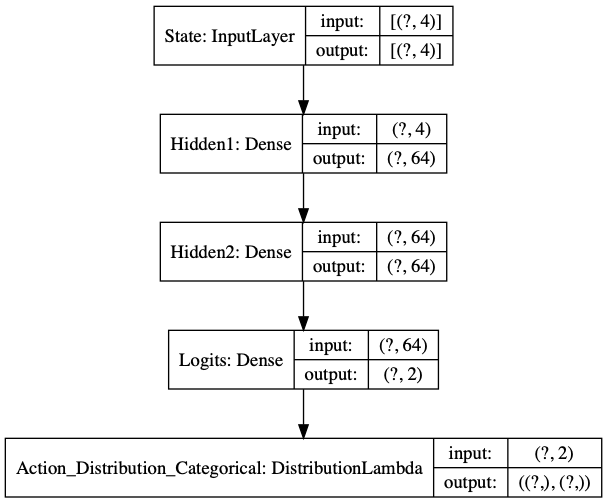

In [12]:
tf.keras.utils.plot_model(policy, show_shapes=True)

## 3. Agente REINFORCE

Uma vez que já nos famialiarizamos com a construção de modelos via Keras e com as particularidades de uma política estocástica implementada como modelo probabilístico (via distribuição categórica), podemos começar a implementar a versão inicial do algoritmo *REINFORCE*. Lembre-se que, pela teoria desenvolvida em aula, o gradiente utilizado para otimizar a política é dado por:

$$
\nabla_\theta J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta} \left [ \sum_{t=0}^{T-1} \nabla_\theta \log \pi_\theta(\mathbf{a}_t|\mathbf{s}_t) \hat{R}(\tau)\right ]~,
$$
onde $\hat{R}(\tau) = \sum_{t=0}^{T-1} r_{t+1}$ é retorno de uma trajetória simulada no ambiente
$
\tau = (\mathbf{s}_0, \mathbf{a}_0, r_1, \mathbf{s}_1, \mathbf{a}_1, r_2, \cdots, \mathbf{s}_{T-1}, \mathbf{a}_{T-1}, r_{T}, s_{T}) \sim \pi_\theta.
$

Como não é possível calcular analiticamente esse valor esperado no caso geral, estimaremos via **Monte-Carlo** o gradiente da política:

$$
\nabla_\theta J(\theta) \approx \frac{1}{N} \sum_{k=1}^K \sum_{t=0}^{T-1} \nabla_\theta \log \pi_\theta(\mathbf{a}_t^{(k)}|\mathbf{s}_t^{(k)}) \hat{R}(\tau^{(k)})~,
$$

onde o índice $k$ denota vetores da $k$-ésima trajetória amostrada. 

### 3.1 Surrogate Loss e diferenciação automática

Para usar a diferenciação automática no TensorFlow (i.e., computar gradientes via `tape.gradient`) é necessário definir uma função objetivo. No contexto de aprendizado de máquina no geral, essa função objetivo é tipicamente chamada de *loss* e a maioria dos pacotes de *Deep Learning* tenta **minimizar essa função**.

Dessa forma, como estamos querendo maximizar o desempenho do agente denotado por $J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta} [R(\tau)]$ deveremos minimizar o negativo de $J(\theta)$. Para o Policy Gradients a função de *loss* que vamos utilizar é dada por:

$$
\hat{J}(\theta) = \frac{1}{N} \sum_{k=1}^K \sum_{t=0}^{T-1}  \log \pi_\theta(\mathbf{a}_t^{(k)}|\mathbf{s}_t^{(k)}) \hat{R}(\tau^{(k)})~.
$$

> **IMPORTANTE**: note que em geral $\hat{J}(\theta) \neq J(\theta)$, no entanto, $\nabla_\theta \hat{J}(\theta) \approx \nabla_\theta J(\theta)$. Essa é a razão pela qual $\hat{J}$ é chamada de *surrogate loss*; *surrogate* em português significa "substituto". 

---

**<font color="red">EXERCÍCIO-PROGRAMA:</font>**

Nesse exercício você deverá codificar o método `_loss_fn` da classe `REINFORCE` que será reponsável por implementar a função de *loss* do *Policy Gradient*.

> **Nota 1**: observe que cada `batch` corresponde a um dicionário de listas, onde cada lista corresponde a um conjunto de episódios. Por exemplo, `batch["states"][k]` devolve os estados do k-ésimo episódio amostrado.

> **Nota 2**: No NumPy e no TensorFlow você pode trabalhar com operações binárias "vetorizadas", isto é, você pode por exempo multiplicar 2 conjuntos de vetores `x` e`y` de mesmo tamanho (e.g., `x.shape == y.shape == (N, dim)`, onde `N` representa o número de vetores e `dim` o tamanho do vetor) simplesmente executando `x * y`. Essa técnica é conhecida como *[broadcasting](https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html)* de vetores (ou array n-dimensionais no caso mais geral).

> **Nota 3**: pode ser útil utilizar as funções de agregação `np.sum` e `tf.reduce_sum`.


In [54]:
class REINFORCE(RLAgent):
    """
    Classe que implementa os componentes de um agente que aprende pelo REINFORCE.

    Args:
        obs_space:     especificação do espaço de observações do ambiente.
        action_space:  especificação do espaço de ações do ambiente.
        config (dict): (opcional) configurações de hiper-parâmetros.
    """
    
    def __init__(self, obs_space, action_space, config=None):
        super(REINFORCE, self).__init__(obs_space, action_space, config)
        
        self.memory = OnPolicyReplay()
        self.policy = build_discrete_policy(self.obs_space, self.action_space, config["hidden_layers"], config["activation"])
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=config["learning_rate"])

    def act(self, obs):
        """
        Escolhe uma ação para ser tomada dada uma observação do ambiente.
        
        Args: 
            obs: observação do ambiente.
        
        Return:
            action: ação válida dentro do espaço de ações.
        """

        return self._act(obs).numpy()
    
    @tf.function
    def _act(self, obs):
        action_dist = self.policy(obs[None,:])
        return action_dist.sample()[0]

    def observe(self, obs, action, reward, next_obs, done):
        """
        Registra na memória do agente uma transição do ambiente.

        Args:
            obs:            observação do ambiente antes da execução da ação.
            action:         ação escolhida pelo agente.
            reward (float): escalar indicando a recompensa obtida após a execução da ação.
            next_obs:       nova observação recebida do ambiente após a execução da ação.
            done (bool):    True se a nova observação corresponde a um estado terminal, False caso contrário.

        Return:
            None
        """
        self.memory.update(obs, action, reward, next_obs, done)

    def learn(self):
        """
        Método de treinamento do agente. A partir das experiências de sua memória,
        o agente aprende um novo comportamento.

        Args: 
            None

        Return:
            None
        """     
        if self.memory.batch_size < self.config["train_batch_size"]:
            return
        
        batch = self.memory.sample()

        with tf.GradientTape() as tape:
            loss = self._loss_fn(batch)
            gradients = tape.gradient(loss, self.policy.trainable_weights)

        self.optimizer.apply_gradients(zip(gradients, self.policy.trainable_weights))
        
        grad_norm = [(w.name, tf.norm(grad).numpy()) for w, grad in zip(self.policy.trainable_weights, gradients)]
      
        return loss.numpy(), grad_norm

    def _loss_fn(self, batch):
        """
        Calcula a função loss do policy gradients para um `batch` de trajetórias/episódios.
        
        Um `batch` agrega listas de arrays n-dimensionais. Cada lista (e.g., batch["states"],
        batch["actions"], batch["rewards"]) tem o tamanho do número de episódios. Por exemplo,
        batch["states"][k] devolve um array n-dimensional para o k-ésimo episódio. Este array
        tem como primeira dimensão o número de timesteps do k-ésimo episódio.

        Args:
            batch (Dict[str, List[np.ndarray]]): dicionário para acesso às listas de estados, ações e recompensas. 
        
        Return:
            loss (tf.Tensor): média sobre os episódios do surrogate loss function.
            
        """
        
        states, actions, rewards = batch["states"], batch["actions"], batch["rewards"]
        n_episodes = len(states)
        
        loss = 0.0

        # SEU CÓDIGO AQUI ===================================

        for k in range(n_episodes):
            action_dist = self.policy(states[k])
            log_probs = action_dist.log_prob(actions[k])

            R_k = np.sum(rewards[k])

            weighted_log_probs = log_probs * R_k

            loss += - tf.reduce_sum(weighted_log_probs)
            
        loss /= n_episodes
        
        # ===================================================

        assert loss.shape == (), "loss deve ser um escalar"
        assert isinstance(loss, tf.Tensor)

        return loss

In [55]:
from pprint import pprint

env = gym.make("CartPole-v0")
obs_shape = env.observation_space.shape
action_space = env.action_space

# print(env.observation_space, env.action_space)

config = {
    # policy net
    "hidden_layers": [64, 64],
    "activation": "relu",

    # optimization
    "learning_rate": 5e-4,

    # training
    "train_batch_size": 3000,
}

agent = REINFORCE(env.observation_space, env.action_space, config=config)

n_episodes = 5
n_timesteps = np.random.randint(2, 5, size=(n_episodes,))
# print(n_timesteps)

batch = {
    "states":  [ np.random.normal(size=(n_timesteps[k], obs_shape[0]))    for k in range(n_episodes)],
    "actions": [ np.random.randint(0, 2, size=(n_timesteps[k],))   for k in range(n_episodes)],
    "rewards": [ np.ones(n_timesteps[k])   for k in range(n_episodes)]
}

agent._loss_fn(batch)


<tf.Tensor: shape=(), dtype=float32, numpy=5.3362565>

Para testar a sua implementação, rode o código abaixo. Para os parâmetros definidos abaixo no dicionário de `config`, você deve obter um `avg_loss` entre 300.0 e 600.0. Note que estamos usando simulação de Monte-Carlo então o resultado pode variar um pouco.

> **IMPORTANTE**: caso a sua implementação não esteja passando no teste abaixo (em várias tentativas consecutivas) e você achar que sua implementação está correta, chame o monitor ou um dos instrutores. 

In [56]:
env = gym.make("CartPole-v0")

config = {
    # policy net
    "hidden_layers": [64, 64],
    "activation": "relu",

    # optimization
    "learning_rate": 5e-4,

    # training
    "train_batch_size": 3000,
}

agent = REINFORCE(env.observation_space, env.action_space, config=config)

avg_loss, trials = 0.0, 10
for j in range(trials):
    n_episodes = 100
    _ = utils.runner.evaluate(agent, env, n_episodes, render=False)
    loss = agent._loss_fn(agent.memory.sample())
    avg_loss += loss

avg_loss /= trials
    
print(f"Você obteve avg_loss = {avg_loss}.")
assert 300.0 <= avg_loss <= 600.0
print("\n>> Sua implementação está provavelmente correta... Parabéns! :)")

[100% /   0s] episode = 100/100 -> total_reward =    22.0000, episode_length =  22
[100% /   0s] episode = 100/100 -> total_reward =    50.0000, episode_length =  50
[100% /   0s] episode = 100/100 -> total_reward =    35.0000, episode_length =  35
[100% /   0s] episode = 100/100 -> total_reward =    19.0000, episode_length =  19
[100% /   0s] episode = 100/100 -> total_reward =    20.0000, episode_length =  20
[100% /   0s] episode = 100/100 -> total_reward =    28.0000, episode_length =  28
[100% /   0s] episode = 100/100 -> total_reward =    10.0000, episode_length =  10
[100% /   0s] episode = 100/100 -> total_reward =    42.0000, episode_length =  42
[100% /   0s] episode = 100/100 -> total_reward =    11.0000, episode_length =  11
[100% /   0s] episode = 100/100 -> total_reward =    29.0000, episode_length =  29
Você obteve avg_loss = 466.674560546875.

>> Sua implementação está provavelmente correta... Parabéns! :)


---

## 4. Treinamento do agente

Para treinar o agente seguiremos o algoritmo visto em aula.

<img src="img/reinforce.png" alt="Agent-Env Loop" style="width: 750px;"/>

No entanto, para agilizar o tutorial e garantir que todos tenham a mesma implementação do ciclo do agente-ambiente, disponibilizados nos métodos `utils.runner.train` e `utils.runner.evaluate` que se encarregam em facilitar a coleta de experiências pelo agente em um ambiente.

A função `utils.runner.evaluate` simula um dado número de episódios completos no ambiente a fim de avaliar o retorno médio do agente. Por outro lado, a função `utils.runner.train` coleta o certo número de passos no ambiente e chama o método `learn` do agente que recupera de sua memória um `batch` de experiências para estimar o *policy gradient*.

Nessa seção, você não precisará implementar nada para treinar o agente. Mas vai rodar um primeiro experimento mais demorado para avaliar o desempenho do agente.

> **Observação**: embora não seja necessário, caso tenha curiosidade em saber mais sobre essas funções você pode acessar o código via o *File Browser* na lateral do Jupyter Lab na pasta `utils/`.

### 4.1 Otimização & Gradiente Ascendente


<img src="img/sgd.png" alt="Agent-Env Loop" style="width: 300px;"/>

Para treinar o agente com o algoritmo do *Policy Gradients* iremos usar um método de otimização baseado na técnica de **[Gradiente Ascendente](https://en.wikipedia.org/wiki/Gradient_descent)**:

$$
\theta \leftarrow \theta + \alpha \nabla_\theta J(\theta)
$$

Se você prestou atenção na definição da classe `REINFORCE` deve ter notado que:
1. No construtor `__init__` da classe é instanciado um otimizador `self.optimizer = tf.keras.optimizers.Adam(learning_rate=...)`; e
2. No método `learn`, o otimizador é chamado para aplicar os gradients `self.optimizer.apply_gradients(...`).

Nessa parte prática optamos por usar um dos otimizadores mais utilizados em aprendizado por máquina, e.g., [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam).

> **IMPORTANTE**: não precisaremos implementar o algoritmo de gradiente ascendente, isto é, o otimizador irá se encarregar disso para nós!

> **Observação**: a bilioteca do TensorFlow conta com inúmeros outros otimizadores (e.g., https://www.tensorflow.org/api_docs/python/tf/keras/optimizers).Uma apresentação mais detalha desses otimizadores está fora do escopo desse curso. Para aqueles interessados em aprender sobre otimizadores, sugerimos o tutorial disponível em https://ruder.io/optimizing-gradient-descent/.


### 4.2 Avaliação do agente (antes do treinamento) 

Reinicialize o agente executando o código abaixo:

In [ ]:
env = gym.make("CartPole-v0")

config = {
    # policy net
    "hidden_layers": [64, 64],
    "activation": "relu",

    # optimization
    "learning_rate": 5e-4,

    # training
    "train_batch_size": 3000,
}

agent = REINFORCE(env.observation_space, env.action_space, config=config)

Antes de treinarmos o agente, é importante ter alguma referência sobre seu desempenho inicial. Execute o código abaixo para coletar `n_episodes` e obter o retorno médio por episódio.

In [ ]:
n_episodes = 1000
_, total_rewards, _ = utils.runner.evaluate(agent, env, n_episodes, render=False)
batch = agent.memory.sample()

print(f"\n>> O retorno médio obtido em {n_episodes} episódios foi {np.mean(total_rewards)}")
print(f">> Note que para o problema do CartPole-v0 ser considerado resolvido seria necessário obter pelo menos {env.spec.reward_threshold}")

Outro ponto importante para se ter em mente antes do treinamento é a inicialização da política. É fundamental iniciar o treinamento com uma política que aproxima uma distribuição uniforme. Dessa forma, garantimos que o agente começará a interagir com o ambiente sem estar enviesado em suas escolhas das ações.

Execute o comando abaixo para avaliar as distribuições das ações para algumas observações que você acabou de coletar. Verifique que independentemente da observação, o agente não tem nenhuma predileção muito forte por certa ação. 

In [ ]:
plot_action_distribution(agent, batch)

Por fim, execute o comando abaixo para inspecionar visualmente alguns episódios. Note que como o agente ainda não aprendeu nada, **cada episódio falha muito rapidamente** (e.g., no caso do *CartPole* isso quer dizer que o carrinho não consegue equilibrar o mastro e por isso este cai muito rapidamente).

In [ ]:
n_episodes = 10
_ = utils.runner.evaluate(agent, env, n_episodes, render=True)

### 4.3 Aprendendo melhores políticas

Finalmente vamos treinar o agente. Note que para 1 milhão de passos de interação no ambiente a simulação deve demorar alguns poucos minutos.

> **Observação**: lembra quando dissemos na aula que aprendizado por reforço precisa de muitos dados? Para um problema relativamente simples como o *CartPole* em geral é necessário dezenas ou centenas de milhares para um algoritmo do estado-da-arte. Para o REINFORCE, que é um dos algoritmos mais básicos, precisaremos de mais experiências. Nas próximas aulas vamos estudar técnicas mais avançadas para reduzir o número de amostras necessárias para obtermos o mesmo desempenho.  

In [ ]:
total_timesteps = 1_000_000
timesteps, losses, grads, total_rewards, avg_total_rewards = utils.runner.train(agent, env, total_timesteps)

### 4.4 Visualizando a curva de aprendizado e outras métricas do treinamento 

Talvez a métrica mais importante para se avaliar ao longo do treinamento de um agente de RL seja o retorno esperado dos episódios. Execute o código abaixo para visualizar o retorno médio por *batch* de trajetórias e uma média móvel sobre os últimos 100 episódios.

Lembre-se que para o *CartPole* ser considerado como resolvido é necessário obter pelo menos 195.0 de retorno médio nos últimos 100 episódios. 

> **Atenção**: note o quão "ruidoso" é o treinamento do REINFORCE na versão básica que acabamos de implementar. Às vezes o retorno aumenta, logo em seguida diminui, e depois melhora novamente. Mesmo suavizando a curva dos retornos através uma média móvel, ainda é possível visualizar que o treinamento está longe de ser estável. 

In [ ]:
plot_returns(timesteps, total_rewards, avg_total_rewards)

Execute o código abaixo para visualizar o *policy gradient loss*. Lembre-se que usamos essa quantidade para estimar o gradiente da política e não para avaliar o desempenho do agente. Embora para o caso do REINFORCE  a *loss* pareça estar correlacionada com o retorno médio, isso não ocorre no geral uma vez que para algoritmos mais avançados termos auxiliares aparecerão do cálculo da *loss function*.

In [ ]:
plot_losses(losses)

Também pode ser útil para *debuggar* possíveis problemas ter alguma ideia da norma $\mathcal{L}_2$ dos gradientes, $||\nabla_\theta J(\theta)||_2$, ao longo do treinamento.

Em particular, é importante garantir que a magnitude da norma dos gradientes não "exploda".

Se você implementou tudo corretamente (e não alterou nada na arquitetura do modelo da política), a maioria dos valores das normas devem estar entre 500 e 1500, com alguns picos até 4000.

In [ ]:
plot_gradient_norms(grads)

Após o treinamento, compare o novo desempenho do agente em termos de retorno médio, distribuições das ações e comportamento.

In [ ]:
n_episodes = 100
timesteps, total_rewards, avg_total_rewards = utils.runner.evaluate(agent, env, n_episodes, render=False)
batch = agent.memory.sample()

print(f"\n>> O retorno médio obtido em {n_episodes} episódios foi {np.mean(total_rewards)}")

Visualize a nova distribuição de ações:

In [ ]:
plot_action_distribution(agent, batch)

Observe que se tudo correu conforme o esperado o agente aprendeu a equilibrar o mastro movendo o carrinho de acordo. Ainda há como melhorar um pouco, mas já é possível verificar que o agente aprendeu algo bastante razoável.

In [ ]:
n_episodes = 10
_ = utils.runner.evaluate(agent, env, n_episodes, render=True)

---

**<font color="red">QUESTÕES:</font>**

1. Como você compara as distribuições das ações (isto é, a política estocástica) antes e depois do treinamento? O que você diria sobre a escolha de ações pelo agente no início e no final do treinamento?
2. Como você justificaria o ruído (ou em outras palavras a alta variabilidade) nos retornos dos episódios obtidos durante o treinamento? Como você relaciona o *policy gradient loss* e a norma dos gradientes com os retornos obtidos?

---

## 5. Bônus - Experimentos

Nessa seção opcional, vamos tentar entender o efeito na curva de treinamento de alguns hiper-parâmetros do algoritmo REINFORCE. Em particular, iremos variar a taxa de aprendizado (e.g., *learning rate*) e o tamanho do *batch* de treinamento.

Execute o código abaixo para rodar 4 experimentos. Note que irá demorar certa de 15 e 30 minutos dependendo da máquina. A medida que os resultados forem sendo visualizados, tente formular hipóteses sobre o efeito do hiper-parâmetro. 

In [ ]:
def run_experiment(trial, env_id, config, total_timesteps):
    env = gym.make(env_id)
    agent = REINFORCE(env.observation_space, env.action_space, config)
    timesteps, losses, _, total_rewards, avg_total_rewards = utils.runner.train(agent, env, total_timesteps, verbose=True)
    return timesteps, losses, total_rewards, avg_total_rewards

In [ ]:
n_trials = 3
total_timesteps = 1_000_000

env_id = "CartPole-v0"
base_config = {
        # policy net
    "hidden_layers": [64, 64],
    "activation": "relu",

    # optimization
    "optimizer": "adam",
    "learning_rate": None,

    # training
    "train_batch_size": None,
}

learning_rates = [1e-2, 1e-4]
batch_sizes = [1000, 10000]

for lr in learning_rates:
    for bs in batch_sizes:        
        experiment_config = {"learning_rate": lr, "train_batch_size": bs}
        config = {**base_config, **experiment_config}
        
        print(f">> Experiment: {experiment_config}")
        results = []
        for trial in range(n_trials):
            print(f"Starting trial {trial+1} ...")
            results.append(run_experiment(trial, env_id, config, total_timesteps))
        
        plot_experiments(results, experiment_config)

---

**<font color="red">QUESTÕES:</font>**

1. Fixando o `batch_size`, como você compararia os resultados obtidos para cada valor de `learning_rate` em termos do desempenho final do agente e estabilidade do treinamento?
2. Fixando o `learning_rate`, como você compararia os resultados obtidos para cada valor de `batch_size` em termos do desempenho final do agente e estabilidade do treinamento?
3. Se você tivesse possibilidade (e paciência :)) de coletar 10 milhões de passos de interação com ambiente qual dentre as quatro configurações de hiper-parâmetros você escolheria? E se tivesse apenas 100.000 ?